<a href="https://colab.research.google.com/github/Jesuisgmo/transcriptomics_homework/blob/main/homework_2/homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id 17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk
To: /content/EM_dataset.csv
100% 12.6k/12.6k [00:00<00:00, 17.1MB/s]


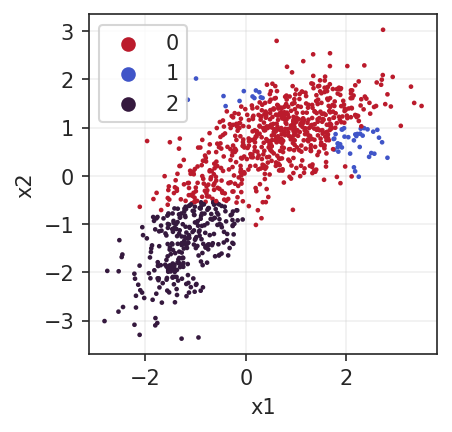

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import logsumexp

df = pd.read_csv("EM_dataset.csv")

# Зададим параметры ϕ,μ1,σ1,μ2,σ2 случайно

def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())

params = {
    "phi1" : np.random.uniform(0, 0.5), # Доля точек, принадлежащих к кластеру 1
    "phi2" : np.random.uniform(0, 0.5), # Доля точек, принадлежащих к кластеру 2

    "mu1" : np.random.normal(0, 1, size=2), # Центр распределения 1
    "mu2" : np.random.normal(0, 1, size=2), # Центр распределения 2
    "mu3" : np.random.normal(0, 1, size=2), # Центр распределения 3

    "sigma1": get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma2" : get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma3" : get_random_psd() # У 2d Гауссианы таким образом задаётся дисперсия
}

# for param in params:
#   print(f"{param}:")
#   print(params[param], "\n")

# Распределим точки в соответствии со сгенерированными Гауссианами

X = df.values

def E_step(X, params, draw=False):
  LogLikelihood = A = np.log([
      stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X),
      stats.multivariate_normal(params["mu2"], params["sigma2"]).pdf(X),
      stats.multivariate_normal(params["mu3"], params["sigma3"]).pdf(X)
  ])
  logPrior = B = np.log([1 - params["phi1"]+params["phi2"], params["phi2"], params["phi1"]])
  logPosterior = D = logPrior + LogLikelihood.T
  RealSoftMax = C = logsumexp(logPosterior, axis=1)
  probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)

  return RealSoftMax, probabilities

# Запустим и отрисуем

total_prob, probabilities = E_step(X, params)
# print("total_prob: ", total_prob, "probabilities: ", probabilities)

# Оптимизируем параметр  θ  по тому, как мы определили принадлежность точек к кластерам на позапрошлом шаге

def M_step(X, params, probabilities):
  prob_1 = probabilities[:, 0]
  prob_2 = probabilities[:, 1]
  prob_3 = probabilities[:, 2]

  # Вычисление новых значений
  # Пропорция = prior
  phi1 = prob_1.sum() / len(X)
  phi2 = prob_2.sum() / len(X)

  # Среднее
  mu1 = prob_1.dot(X) / np.sum(prob_1)
  mu2 = prob_2.dot(X) / np.sum(prob_2)
  mu3 = prob_3.dot(X) / np.sum(prob_2)

  # Дисперсия
  sigma1 = (X - mu1).T.dot((X - mu1) * np.array([prob_1]).T) / np.sum(prob_1)
  sigma2 = (X - mu2).T.dot((X - mu2) * np.array([prob_2]).T) / np.sum(prob_2)
  sigma3 = (X - mu3).T.dot((X - mu3) * np.array([prob_3]).T) / np.sum(prob_3)

  return {
      "phi1" : phi1, "phi2" : phi2,
      "mu1" : mu1, "mu2" : mu2, "mu3" : mu3,
      "sigma1": sigma1, "sigma2": sigma2, "sigma3": sigma3
  }

# Сделаем так, чтобы это выполнялось до тех пор, пока LogLikelihood не перестанет уменьшаться меньше, чем на 0.00000001.

def run_EM(X, params, draw=False):
    import imageio
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params, draw=draw)
        avg_allprob.append(np.mean(allprob))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.000000001:
            break
        params = M_step(X, params, probabilities)

    loglikelihood, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

# Запустим и отрисуем

pred, prob, allprob = run_EM(X, params, draw=True)
# print("pred: ", pred, "prob: ", prob, "allprob: ", allprob)

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: sns.color_palette("coolwarm", n_colors=50)[-1],
                         1: sns.color_palette("coolwarm", n_colors=50)[0],
                         2: sns.color_palette("rocket")[0]})
ax.grid(alpha=0.3)
plt.show()